### Wasserstein GAN CelebA

In [1]:
import os
import cv2
import PIL
import glob
import time
import random
import imageio
import warnings
import numpy as np
from IPython import display
import moviepy.editor as mpy
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow_docs.vis.embed as embed

In [3]:
print(tf.__version__)
warnings.filterwarnings('ignore')

2.4.0


---
#### Call Out GPU

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


---
#### Parameter Settings

In [5]:
IMGWD = 64
IMGHG = 64
CHANNEL = 3
NOISE_DIM = 100

DEMO_ROW = 8
DEMO_COL = 8
NO_EXAMPLES = DEMO_ROW * DEMO_COL

BUFFER_SIZE = 12345
BATCH_SIZE = 256
EPOCHS = 500
LEARNING_RATE = 2.0e-04
ClipLo = -0.01
ClipHi = 0.01

IMG_PATH = 'datasets/img_align_celeba/'
CHKPOINT_DIR = 'checkpoints/WGAN_CelebA/'
RESULT_DIR = 'result/WGAN_CelebA/final result/'
GIF_DIR = 'result/WGAN_CelebA/gifs/'

for _dir in [CHKPOINT_DIR, RESULT_DIR, GIF_DIR]:
    if not os.path.isdir(_dir):
        os.makedirs(_dir)
    
CHKPOINT_PREFIX = os.path.join(CHKPOINT_DIR, "ckpt")

---
#### Load Datasets and Preprocessing

In [6]:
def load_image(image_path):
    img = tf.io.read_file(IMG_PATH + image_path)
    img = tf.image.decode_jpeg(img, channels=CHANNEL)
    img = tf.image.resize(img, (IMGHG, IMGWD))
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    
    return img

got 202599 files.


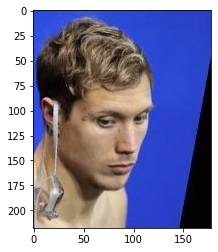

In [7]:
files = os.listdir(IMG_PATH)
print('got {} files.'.format(len(files)))
img = cv2.cvtColor(cv2.imread(IMG_PATH + random.choice(files)), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(files)
train_dataset = train_dataset.map(load_image)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, True)

---
#### Create Model
##### 1. The Generator

In [9]:
# Conv2DTranspose: to produce an image from random noise
# Start with a Dense layer to take a seed as input, then upsample several times
# until the desired image size of 28x28x1 reached
def generator_model():
    # z-shape
    zh, zw = IMGHG // 4, IMGWD // 4
    inputs = keras.Input(shape=(NOISE_DIM,))
    
    x = layers.Dense(1024)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Dense(zh * zw * 256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Reshape(target_shape = (zh, zw, 256))(x)
    x = layers.Conv2DTranspose(filters=32,kernel_size=5,strides=2,padding="SAME")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    outputs = layers.Conv2DTranspose(filters=CHANNEL,
                                     kernel_size=5,
                                     strides=2,
                                     padding="SAME",
                                     activation='tanh')(x)
    model = keras.Model(inputs, outputs, name='Generator')
    return model

##### 2. The Discriminator

In [10]:
def discriminator_model():
    inputs = keras.Input(shape=(IMGWD, IMGHG, CHANNEL))
    
    x = layers.Conv2D(filters=32,kernel_size=5,strides=(2,2),padding="SAME")(inputs)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(filters=128,kernel_size=5,strides=(2,2),padding="SAME")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs, name='Discriminator')
    return model

##### 3. Define optimizers

In [11]:
gen_optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)
disc_optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)

##### 4. Make Checkpoints

In [12]:
generator = generator_model()
discriminator = discriminator_model()

checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=disc_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

---
#### Training Function

In [13]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def generator_train_step(images):
    noise = tf.random.normal([images.shape[0], NOISE_DIM]) #images.shape[0]
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        disc_loss = tf.reduce_mean(fake_output)
        gen_loss = - disc_loss
        disc_loss = disc_loss - tf.reduce_mean(real_output)
        
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    
    return gen_loss, disc_loss

In [14]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def discriminator_train_step(images):
    noise = tf.random.normal([images.shape[0], NOISE_DIM])
    with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        disc_loss = tf.reduce_mean(fake_output)
        gen_loss = - disc_loss
        disc_loss = disc_loss - tf.reduce_mean(real_output)
        
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    
    # Clipping
    for variable in discriminator.trainable_variables:
        variable.assign(tf.clip_by_value(variable, ClipLo, ClipHi))
    
    return gen_loss, disc_loss

In [15]:
# ratio of training step Discriminator:Generator = 5:1
train_step = (discriminator_train_step,
              discriminator_train_step,
              discriminator_train_step,
              discriminator_train_step,
              discriminator_train_step,
              generator_train_step)

WGAN_Critic = len(train_step)

---
##### Visualization function

In [16]:
def training_losses(gen_losses=[], disc_losses=[]):
    plt.figure()
    plt.plot(range(EPOCHS), disc_losses, color = "blue", label = "Discriminator Loss")
    plt.plot(range(EPOCHS), gen_losses, color = "red",  label = "Generator Loss")

    plt.legend(loc = "upper right")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("WGAN Training Loss")
    plt.show()

In [17]:
def produce_pltgrid(imgs, demo_row, demo_col, path=None):
    imgh, imgw, imgc = imgs[0].shape
    pltgrid = np.zeros((imgh * demo_row, imgw * demo_col, imgc), np.uint8)
    for _idx, img in enumerate(imgs):
        row, col = divmod(_idx, demo_col)
        pltgrid[row * imgh : (row+1) * imgh, col * imgw : (col+1) * imgw, :] = img
    if path is not None:
        imageio.imwrite(path, pltgrid)
        
    return pltgrid

In [18]:
def make_gif(imgs, filename, duration):
    fps = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(fps * t)], duration=duration)
    clip.write_gif(filename, fps=fps)

---
#### Training Process
##### checkboard effect: https://distill.pub/2016/deconv-checkerboard/

In [19]:
seed = tf.random.normal([NO_EXAMPLES, NOISE_DIM])
gen_losses, disc_losses, image_results = [], [], []
train_idx = 0
fraction = float(BATCH_SIZE) / float(len(files))

def train(datasets, epochs):
    global seed, gen_losses, disc_losses, image_results, train_idx, WGAN_Critic
    
    for epoch in range(epochs):
        start = time.time()
        total_gen_loss, total_disc_loss = 0.0, 0.0
        
        for image_batch in datasets:
            gen_loss, disc_loss = train_step[train_idx % WGAN_Critic](image_batch)
            train_idx += 1
            total_gen_loss += gen_loss.numpy()
            total_disc_loss += disc_loss.numpy()
            
        gen_losses.append(total_gen_loss * fraction)
        disc_losses.append(total_disc_loss * fraction)
        
        predicts = generator(seed, training=False) * 127.5 + 127.5
        predicts = predicts.numpy().astype(np.uint8)
        
        if epoch == epochs - 1:
            pltgrid = produce_pltgrid(predicts, DEMO_ROW, DEMO_COL, RESULT_DIR + 'image_epoch_{:4d}.png'.format(epoch + 1))
        else:
            pltgrid = produce_pltgrid(predicts, DEMO_ROW, DEMO_COL, None)
        image_results.append(pltgrid)
        
        # Save model at every 15 epochs
        if (epoch + 1) % 15 == 0 or epoch == epochs - 1:
            checkpoint.save(file_prefix=CHKPOINT_PREFIX)
            # Produce images for the GIF results
            display.clear_output(wait=True)
            
            plt.figure()
            plt.imshow(cv2.cvtColor(pltgrid[...,:], cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.title("Epoch %d" % (epoch+1))
            plt.show()
            
            print('time for epoch {} is {} sec'.format(epoch + 1, time.time() - start)) 

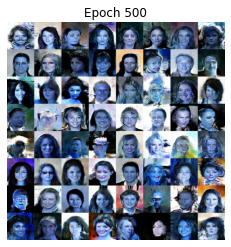

time for epoch 500 is 63.534064292907715 sec


In [20]:
train(train_dataset, EPOCHS)

In [21]:
make_gif(np.array(image_results), GIF_DIR + 'wgan.gif', duration=10)

t:   0%|          | 0/500 [00:00<?, ?it/s, now=None]

MoviePy - Building file result/WGAN_CelebA/gifs/wgan.gif with imageio.


---
#### Training Losses Visualization

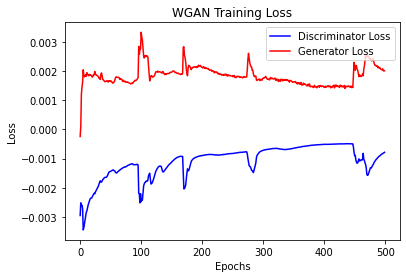

In [22]:
training_losses(gen_losses, disc_losses)